 ### Estimation of Stationary Sleep-segments (ESS) Algorithm Implementation
 
 #### It is described in this paper https://ieeexplore.ieee.org/abstract/document/7052479
 

In [1]:
import os
import numpy as np

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.model_selection import KFold
#from google.colab import files


## Prepare data

In [2]:
#data_path = os.path.join("/content/gdrive/My Drive/", "DRU-MAWI-project/ICHI14_dataset/data")
data_path = os.path.join("ICHI14_dataset/data")
patient_list = ['002','003','005','007','08a','08b','09a','09b', '10a','011',"012", '013','014','15a','15b','016',
            '017','018','019','020','021','022','023','025','026','027','028','029','030','031','032',
            '033','034','035','036','037','038','040','042','043','044','045','047','048','049', '050','051']

In [3]:
train_patient_list, test_patient_list = train_test_split(patient_list, random_state=152, test_size=0.3)
test_patient_list, valid_patient_list = train_test_split(test_patient_list, random_state=151, test_size=0.5)

In [4]:
print(len(patient_list))
print(len(train_patient_list))
print(len(valid_patient_list))
print(len(test_patient_list))

47
32
8
7


In [5]:
print(train_patient_list)
print(valid_patient_list)
print(test_patient_list)

['045', '025', '023', '08a', '022', '012', '029', '043', '037', '028', '011', '042', '10a', '035', '019', '007', '021', '034', '038', '032', '048', '040', '018', '051', '026', '031', '027', '002', '09a', '013', '09b', '030']
['050', '049', '033', '014', '08b', '15a', '016', '047']
['005', '017', '036', '15b', '003', '044', '020']


In [6]:
def change_labels(sample):
    """
    Returns:
    sample - contains only label 1(awake) and 0(sleep) for polisomnography
    """
    
    sample.gt[sample.gt==0] = 8
    sample.gt[np.logical_or.reduce((sample.gt==1, sample.gt==2, sample.gt==3, sample.gt==5))] = 0
    sample.gt[np.logical_or.reduce((sample.gt==6, sample.gt==7, sample.gt==8))] = 1
    
    return sample   

#-------------------------------------------------------------------------

def decoder(sample):
    '''
    Returns: 
    decoded_sample - contains accelerometer and ps data for each sensor record, ndarray of shape (n_records, 4)
    
    '''

    sample = np.repeat(sample, sample.d, axis=0)
    n_records = sample.shape[0]
    decoded_sample = np.zeros((n_records, 4))
    
    decoded_sample[:, 0] = sample.x
    decoded_sample[:, 1] = sample.y
    decoded_sample[:, 2] = sample.z
    decoded_sample[:, 3] = sample.gt
    
    return decoded_sample

#-------------------------------------------------------------------------

def divide_by_windows(decoded_sample, window_len=60):
    """
    Parameters:
    wondow_len - length of each window in seconds, int
    Returns:
    X - accelerometer data, ndarray of shape (n_windows, window_len, 3)
    y - polisomnography data, ndarray of shape (n_windows, )
    """
    
    window_len *= 100
    n_windows = decoded_sample.shape[0] // window_len
    
    X = np.zeros((n_windows, window_len, 3))
    y = np.zeros(n_windows)
    
    for i in range(n_windows):
        X[i] = decoded_sample[window_len * i: window_len * i + window_len, 0: 3]
        
        ones = np.count_nonzero(decoded_sample[window_len*i: window_len*i+window_len, 3])
        if ones >= (window_len / 2):
            y[i] = 1
        else:
            y[i] = 0
                
    return X, y

#-------------------------------------------------------------------------

def get_one_patient_data(data_path, patient, window_len=60):
    
    """
    Returns:
    X, y - for one patient
    """
    
    sample = np.load("%s/p%s.npy"%(data_path, patient)).view(np.recarray)
    sample = change_labels(sample)
    sample = decoder(sample)
    X, y = divide_by_windows(sample, window_len)
    
    return X, y

#-------------------------------------------------------------------------

def get_data_for_model(data_path, patient_list, window_len=60):
    
    """
    Returns:
    X, y - for all patient list, ndarray of shape (n_records, n_features, n_channels=3)
    """
    
    X_all_data = []
    y_all_data = []
    for patient in patient_list:
        X, y = get_one_patient_data(data_path, patient, window_len)
        X_all_data.append(X)
        y_all_data.append(y)
        
    X_all_data = np.concatenate(X_all_data, axis=0)
    y_all_data = np.concatenate(y_all_data, axis=0)
    
    return X_all_data, y_all_data
  
#-------------------------------------------------------------------------

def get_dawnsampled_data(data_path, patient_list, window_len=60, dawnsample="pca", n_components=10, n_windows=10):
    
    """
    Parameters:
    dawnsample - "pca", "mean", "max", "mode", None - determine the type of data reducing
    Returns:
    X, y - reduced data for all patient list and combine several windows data, ndarray of shape (n_records, n_components * n_windows, n_channels=3)
    """
    
    X_all_data = []
    y_all_data = []
    for patient in patient_list:
        X, y = get_one_patient_data(data_path, patient, window_len)
        
        if dawnsample.lower() == "pca":
          X = reduce_data_pca(X, n_components=n_components)
          
        elif dawnsample.lower() == "mean":
          X = reduce_data_mean(X, n_components=n_components)
          
        elif dawnsample.lower() == "max":
          X = reduce_data_max(X, n_components=n_components)
          
        elif dawnsample.lower() == "mode":
          X = reduce_data_mode(X, n_components=n_components)
          
        elif dawnsample.lower() == "simple":
          X = reduce_data_simple(X, n_components=n_components)
        
        elif dawnsample.lower() == "statistic":
          X = reduce_data_statistic(X, n_components=n_components)
        
        elif dawnsample.lower() == "ess":
          X = reduce_data_ess(X, n_components=n_components)
        
        
        X_new = np.zeros((X.shape[0] - n_windows, X.shape[1] * (n_windows + 1), X.shape[2]))
        
        for i in range(0, X.shape[0] - n_windows):
            X_buff = X[i]
            for j in range(1, n_windows + 1):
                X_buff = np.concatenate([X_buff, X[i+j]], axis=0)
            X_new[i] = X_buff                            
    
    
        if n_windows != 0:
          y = y[(n_windows//2): -(n_windows//2)]
      
        
        X_all_data.append(X_new)
        y_all_data.append(y)

        #np.save(("X_p%s.npy"%(patient)), X_new)
        #np.save(("y_p%s.npy"%(patient)), y)
        
    X_all_data = np.concatenate(X_all_data, axis=0)
    y_all_data = np.concatenate(y_all_data, axis=0)
    
    
    
    return X_all_data, y_all_data
  
def reduce_data_pca(X, n_components=300):
    """
    Parameters:
    X - ndarray of shape (n_samples, n_features)
    
    Returns:
    X, y - reduced data, ndarray of shape (n_records, n_features, n_channels=3)
    """
    pca1 = PCA(n_components)
    pca2 = PCA(n_components)
    pca3 = PCA(n_components)
    
    pca1.fit(X[:, :, 0])
    pca2.fit(X[:, :, 1])
    pca3.fit(X[:, :, 2])
    
    X1 = pca1.transform(X[:, :, 0])
    X2 = pca2.transform(X[:, :, 1])
    X3 = pca3.transform(X[:, :, 2])
    
    X_reduced = np.concatenate([X1, X2, X3], axis=1).reshape(X.shape[0], n_components, 3)
    
    return X_reduced
  
  
def reduce_data_max(X, n_components=600):
    """
    Parameters:
    X - ndarray of shape (n_samples, n_features)
    
    Returns:
    X, y - reduced data, ndarray of shape (n_records, n_components, n_channels=3)
    """
   
    
    X_reduced = np.zeros((X.shape[0], n_components, 3))
    window_len = X.shape[1] // n_components
    
    
    for i in range(n_components):
      
      X_reduced[:, i, :] = np.amax(X[:, i * window_len: (i + 1) * window_len, :], axis=1)
      
    
    X_reduced = X_reduced.reshape(X.shape[0], n_components, 3)
    
    return X_reduced
  

def reduce_data_mean(X, n_components=600):
    """
    Parameters:
    X - ndarray of shape (n_samples, n_features)
    
    Returns:
    X, y - reduced data, ndarray of shape (n_records, n_components, n_channels=3)
    """
   
    
    X_reduced = np.zeros((X.shape[0], n_components, 3))
    window_len = X.shape[1] // n_components
    
    
    for i in range(n_components):
      
      X_reduced[:, i, :] = np.mean(X[:, i * window_len: (i + 1) * window_len, :], axis=1)
         
    X_reduced = X_reduced.reshape(X.shape[0], n_components, 3)
    
    return X_reduced
  
    
def reduce_data_mode(X, n_components=600):
    """
    Parameters:
    X - ndarray of shape (n_samples, n_features)
    
    Returns:
    X, y - reduced data, ndarray of shape (n_records, n_components, n_channels=3)
    """
    
    from scipy.stats import mode
   
    X_reduced = np.zeros((X.shape[0], n_components, 3))
    window_len = X.shape[1] // n_components
       
    for i in range(n_components):
      
      X_reduced[:, i, :] = mode(X[:, i * window_len: (i + 1) * window_len, :], axis=1)
         
    X_reduced = X_reduced.reshape(X.shape[0], n_components, 3)
    
    return X_reduced
  
def reduce_data_simple(X, n_components=600):
    """
    Parameters:
    X - ndarray of shape (n_samples, n_features)
    
    Returns:
    X, y - reduced data, ndarray of shape (n_records, n_components, n_channels=3)
    """
   
    X_reduced = np.zeros((X.shape[0], n_components, 3))
    window_len = X.shape[1] // n_components
       
    for i in range(n_components):
      
      X_reduced[:, i, :] = X[:, i * window_len, :]
         
    X_reduced = X_reduced.reshape(X.shape[0], n_components, 3)
    
    return X_reduced

def reduce_data_statistics(X, n_components=600):
    """
    Parameters:
    X - ndarray of shape (n_samples, n_features)
    
    Returns:
    X, y - reduced data, ndarray of shape (n_records, n_components, n_channels=3)
    """
   
    X_reduced = np.zeros((X.shape[0], n_components, 3))
    window_len = X.shape[1] // n_components
       
    for i in range(n_components):
      
      X_reduced[:, i, :] = np.std(X[:, i * window_len: (i + 1) * window_len, :], axis=1)
         
    X_reduced = X_reduced.reshape(X.shape[0], n_components, 3)
    
    return X_reduced


def reduce_data_ess(X, n_components=1):
    """
    Parameters:
    X - ndarray of shape (n_samples, n_features)
    
    Returns:
    X, y - reduced data, ndarray of shape (n_records, n_components, n_channels=1)
    """
   
    X_reduced = np.zeros((X.shape[0], n_components, 1))
    window_len = X.shape[1] // n_components
       
    for i in range(n_components):
      
      X_reduced[:, i, 0] = np.std(X[:, i * window_len: (i + 1) * window_len, 2], axis=1)
         
    X_reduced = X_reduced.reshape(X.shape[0], n_components, 1)
    
    return X_reduced

In [7]:
%%time
X_train, y_train = get_dawnsampled_data(data_path, train_patient_list,
                                        window_len=1, dawnsample="ess", 
                                        n_components=1, n_windows=0)

X_valid, y_valid = get_dawnsampled_data(data_path, valid_patient_list, 
                                        window_len=1, dawnsample="ess", 
                                        n_components=1, n_windows=0)

X_test, y_test = get_dawnsampled_data(data_path, test_patient_list,
                                      window_len=1, dawnsample="ess",
                                      n_components=1, n_windows=0)

Wall time: 35.6 s


In [8]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(X_test.shape)

(987195, 1, 1)
(987195,)
(230140, 1, 1)
(219281, 1, 1)


## ESS algorithm

In [9]:
def compare_std_with_threshold(X_std, std_threshold=6):
    
    X = np.zeros(X_std.shape)
    X[X_std > std_threshold] = 1    
    
    return np.squeeze(X)


def ess_divide_res_for_windows(y, window_len=60):
    """
    1 -awake, 0 - sleep
    Parameters:
    windows_len - int, in seconds - for comparison with same windows in other algorithms
    """
    
    n_windows = y.shape[0] // window_len
    
    y_new = np.zeros(n_windows)
    
    for i in range(n_windows):
     
        ones = np.count_nonzero(y[window_len * i: window_len * i + window_len])
        if ones >= (window_len / 2):
            y_new[i] = 1
        else:
            y_new[i] = 0
                
    return np.squeeze(y_new)


def ess_predict(X, std_threshold=6, interval=600, window_len=1):
    
    """
    Parameters:
    windows_len - int, in seconds - for comparison with same windows in other algorithms
    """
    
    X = compare_std_with_threshold(X, std_threshold=std_threshold)
    
    count = 0
    y = np.ones(X.shape[0])
    
    for i in range(X.shape[0]):
        if X[i] == 0:
            count += 1
            if count >= interval:
                y[i - interval + 1: i + 1] = 0
            
        else:
            count = 0
     
    if window_len > 1:
        y = ess_divide_res_for_windows(y, window_len=window_len)
    
    return y

In [10]:
y_train = ess_divide_res_for_windows(y_train, window_len=60)
y_valid = ess_divide_res_for_windows(y_valid, window_len=60)
y_test = ess_divide_res_for_windows(y_test, window_len=60)

In [11]:
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(16453,)
(3835,)
(3654,)


In [12]:
y_predict = ess_predict(X_test, window_len=60)
y_predict.shape

(3654,)

In [13]:
from sklearn import metrics

In [14]:

print("\nTrain set result: ")
print(metrics.classification_report(y_test, y_predict))
print("Confussion matrix: \n", metrics.confusion_matrix(y_test, y_predict))

accuracy = metrics.accuracy_score(y_test, y_predict)
print("\nAccuracy on train set: ", accuracy)


Train set result: 
             precision    recall  f1-score   support

        0.0       0.68      0.86      0.76      1834
        1.0       0.81      0.60      0.69      1820

avg / total       0.75      0.73      0.73      3654

Confussion matrix: 
 [[1577  257]
 [ 728 1092]]

Accuracy on train set:  0.7304324028461959


In [15]:
y_predict = ess_predict(X_train, window_len=60)

print("\nTrain set result: ")
print(metrics.classification_report(y_train, y_predict))
print("Confussion matrix: \n", metrics.confusion_matrix(y_train, y_predict))

accuracy = metrics.accuracy_score(y_train, y_predict)
print("\nAccuracy on train set: ", accuracy)

y_predict = ess_predict(X_valid, window_len=60)

print("\nValid set result: ")
print(metrics.classification_report(y_valid, y_predict))
print("Confussion matrix: \n", metrics.confusion_matrix(y_valid, y_predict))

accuracy = metrics.accuracy_score(y_valid, y_predict)
print("\nAccuracy on valid set: ", accuracy)

y_predict = ess_predict(X_test, window_len=60)

print("\nTest set result: ")
print(metrics.classification_report(y_test, y_predict))
print("Confussion matrix: \n", metrics.confusion_matrix(y_test, y_predict))

accuracy = metrics.accuracy_score(y_test, y_predict)
print("\nAccuracy on test set: ", accuracy)


Train set result: 
             precision    recall  f1-score   support

        0.0       0.69      0.88      0.77      8760
        1.0       0.80      0.54      0.65      7693

avg / total       0.74      0.72      0.71     16453

Confussion matrix: 
 [[7747 1013]
 [3546 4147]]

Accuracy on train set:  0.7229076764115967

Valid set result: 
             precision    recall  f1-score   support

        0.0       0.69      0.89      0.78      2070
        1.0       0.80      0.53      0.64      1765

avg / total       0.74      0.72      0.71      3835

Confussion matrix: 
 [[1838  232]
 [ 832  933]]

Accuracy on valid set:  0.7225554106910039

Test set result: 
             precision    recall  f1-score   support

        0.0       0.68      0.86      0.76      1834
        1.0       0.81      0.60      0.69      1820

avg / total       0.75      0.73      0.73      3654

Confussion matrix: 
 [[1577  257]
 [ 728 1092]]

Accuracy on test set:  0.7304324028461959


In [16]:
X_all, y_all = get_dawnsampled_data(data_path, patient_list,
                                        window_len=1, dawnsample="ess", 
                                        n_components=1, n_windows=0)

In [17]:
print(X_all.shape)
print(y_all.shape)

(1436616, 1, 1)
(1436616,)


In [18]:
y_predict = ess_predict(X_all, window_len=60)
y_all = ess_divide_res_for_windows(y_all, window_len=60)
print(y_all.shape)
print(y_predict.shape)

(23943,)
(23943,)


In [19]:
print("\nAll set result: ")
print(metrics.classification_report(y_all, y_predict))
print("Confussion matrix: \n", metrics.confusion_matrix(y_all, y_predict))

accuracy = metrics.accuracy_score(y_all, y_predict)
print("\nAccuracy on all set: ", accuracy)


All set result: 
             precision    recall  f1-score   support

        0.0       0.69      0.88      0.77     12692
        1.0       0.80      0.55      0.65     11251

avg / total       0.74      0.72      0.72     23943

Confussion matrix: 
 [[11185  1507]
 [ 5094  6157]]

Accuracy on all set:  0.7243035542747358


In [20]:
X_all, y_all = get_dawnsampled_data(data_path, ["033"],
                                        window_len=1, dawnsample="ess", 
                                        n_components=1, n_windows=0)

In [21]:
print(X_all.shape)
print(y_all.shape)

(33903, 1, 1)
(33903,)


In [22]:
y_predict = ess_predict(X_all, window_len=60)
y_all = ess_divide_res_for_windows(y_all, window_len=60)
print(y_all.shape)
print(y_predict.shape)

(565,)
(565,)


In [23]:
print("\nAll set result: ")
print(metrics.classification_report(y_all, y_predict))
print("Confussion matrix: \n", metrics.confusion_matrix(y_all, y_predict))

accuracy = metrics.accuracy_score(y_all, y_predict)
print("\nAccuracy on all set: ", accuracy)


All set result: 
             precision    recall  f1-score   support

        0.0       0.71      0.88      0.78       330
        1.0       0.74      0.49      0.59       235

avg / total       0.72      0.72      0.70       565

Confussion matrix: 
 [[289  41]
 [120 115]]

Accuracy on all set:  0.7150442477876107


In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

(0, 1.1)

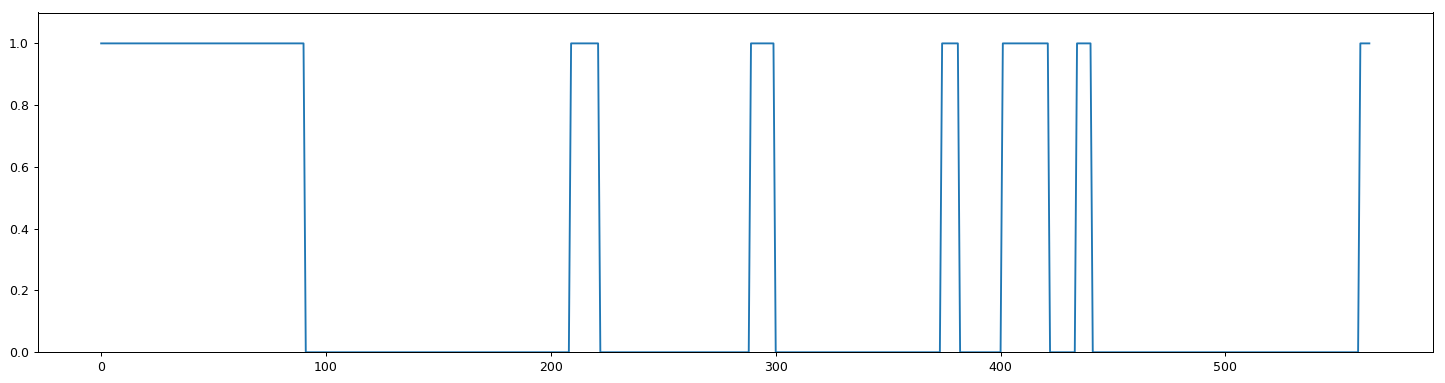

In [25]:
plt.rc('figure', figsize=(20, 5), dpi=90, facecolor='w', edgecolor='k')

ax1 = plt.subplot()
ax1.plot(y_predict)
ax1.set_ylim([0, 1.1])

(0, 1.1)

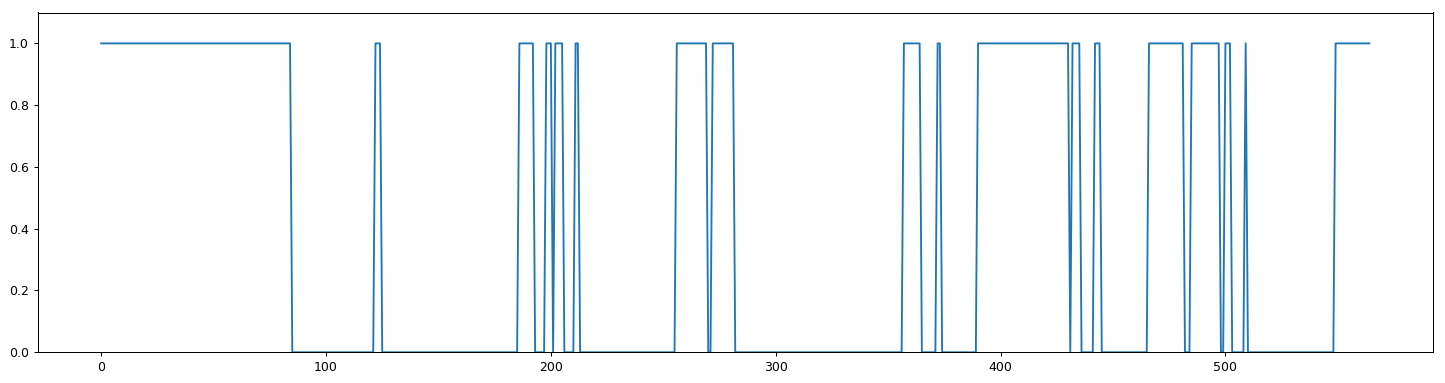

In [26]:
plt.rc('figure', figsize=(20, 5), dpi=90, facecolor='w', edgecolor='k')

ax1 = plt.subplot()
ax1.plot(y_all)
ax1.set_ylim([0, 1.1])

## Calculate median accuracy:

In [27]:
accuracy_list = []

for patient in patient_list:
    X, y = get_dawnsampled_data(data_path, [patient],
                                        window_len=1, dawnsample="ess", 
                                        n_components=1, n_windows=0)
    
    y_predict = ess_predict(X, window_len=1)
    y = ess_divide_res_for_windows(y, window_len=1)
    
    accuracy = metrics.accuracy_score(y, y_predict)
    accuracy_list.append(accuracy)

    

In [28]:
np.median(accuracy_list)    

0.7495602204761347

In [29]:
np.mean(accuracy_list)  

0.721260184623292

In [30]:
max(accuracy_list)


0.971195893275873

In [31]:
len(accuracy_list)

47

In [32]:
kf = KFold(n_splits=5, random_state=5, shuffle=True) # Define the split - into 3 folds 
kf.get_n_splits(patient_list) # returns the number of splitting iterations in the cross-validator

5

In [33]:
n_others_windows = 30

In [35]:
%%time
accuracy_list = []
f1_score_list = []
for train_index, test_index in kf.split(patient_list):
    train_patient_list = [patient_list[i] for i in train_index]
    test_patient_list = [patient_list[i] for i in test_index]
    
    X_train, y_train = get_dawnsampled_data(data_path, train_patient_list,
                                        window_len=1, dawnsample="ess", 
                                        n_components=1, n_windows=0)


    X_test, y_test = get_dawnsampled_data(data_path, test_patient_list,
                                      window_len=1, dawnsample="ess",
                                      n_components=1, n_windows=0)
    
    y_predict = ess_predict(X_train, window_len=60)
    y_train = ess_divide_res_for_windows(y_train, window_len=60)
    
    print("/Train set results:")
    accuracy_train = metrics.accuracy_score(y_train, y_predict)
    f1_train = metrics.f1_score(y_train, y_predict)
    print("Accuracy on train set: ", accuracy_train)
    print("F1-score on train set: ", f1_train)
    
    y_predict = ess_predict(X_test, window_len=60)
    y_test = ess_divide_res_for_windows(y_test, window_len=60)
    
    print("/Test set results:")
    f1_test = metrics.f1_score(y_test, y_predict)
    accuracy_list.append(accuracy)
    f1_score_list.append(f1_test)
    print("Accuracy on test set: ", accuracy)
    print("F1-score on test set: ", f1_test)
    
    print(metrics.classification_report(y_test, y_predict, target_names=["sleep", "awake"]))
    print("Confussion matrix: \n", metrics.confusion_matrix(y_test, y_predict))
    print("\n-------------------------------------------------------")


print("\nMean accuracy =", np.mean(accuracy_list))    
print("\nMean f1-score =", np.mean(f1_score_list))     

/Train set results:
Accuracy on train set:  0.731198808637379
F1-score on train set:  0.6560500884714849
/Test set results:
Accuracy on test set:  0.7309417040358744
F1-score on test set:  0.6312308055752421
             precision    recall  f1-score   support

      sleep       0.64      0.88      0.74      2545
      awake       0.82      0.51      0.63      2596

avg / total       0.73      0.70      0.69      5141

Confussion matrix: 
 [[2244  301]
 [1260 1336]]

-------------------------------------------------------
/Train set results:
Accuracy on train set:  0.7222222222222222
F1-score on train set:  0.647145144076841
/Test set results:
Accuracy on test set:  0.7309417040358744
F1-score on test set:  0.664289353031075
             precision    recall  f1-score   support

      sleep       0.68      0.91      0.78      2503
      awake       0.85      0.54      0.66      2395

avg / total       0.76      0.73      0.72      4898

Confussion matrix: 
 [[2276  227]
 [1091 1304]]

-